In [1]:
import pickle
import os
from glob import glob
import datetime
from matplotlib.backend_bases import register_backend
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# switch to pgf backend -- it is better at producing small pdf files
from matplotlib.backends.backend_pgf import FigureCanvasPgf

register_backend("pdf", FigureCanvasPgf)

# add the correct path to latex into PATH. This depends on the system!
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

# pretty inline display
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# use a more modern style for plots
plt.style.use(style="ggplot")

plt.rcParams.update(
    {
        # Use 9pt font in plots, to match 9pt font in document
        "axes.labelsize": 9,
        "font.size": 9,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "font.family": "serif",
        # TeX setup for inline backend
        "text.usetex": True,
        "text.latex.preamble": r"""
            \usepackage{libertine}
            \usepackage[libertine]{newtxmath}""",
        # TeX setup for pdf backend
        "pgf.rcfonts": False,  # don't setup fonts from rc parameters
        "pgf.texsystem": "pdflatex",
        "pgf.preamble": r"""
            \usepackage{libertine}
            \usepackage[libertine]{newtxmath}""",
    }
)

# widths of figures in inches
TWO_COLUMN_FIG_WIDTH = 7.0056
SINGLE_COLUMN_FIG_WIDTH = 3.337

# Experiment 7

Let's read in the files:

In [2]:
output_dir = "./experiments/experiment7/experiment7_output"
file_pattern = "experiment7_results_*.pickle"

results = []

for file_path in glob(os.path.join(output_dir, file_pattern)):
    with open(file_path, "rb") as f:
        run_results = pickle.load(f)
        results.append(run_results)

print(f"Loaded {len(results)} files")

Loaded 1024 files


Check which runs are missing:

In [3]:
run_ids = tuple(res["run_id"] for res in results)
for i in range(1024):
    if i not in run_ids:
        print(i)

We have all the runs.

These are all the pieces of information a single result contains:

In [4]:
list(results[0].keys())

['run_id',
 'duration',
 'run_length',
 'params',
 'agent_df',
 'lower_tree_query_data',
 'actions',
 'rewards',
 'action_qualities']

Show a preview of the format of action quality estimates. The qualities are given in the order "attack, hide, do nothing".

In [5]:
results[0]["action_qualities"]

,time,estimator,actor,qualities,n_expansions
0,0,0,0,"[-0.12439075225934634, -0.029515989113026574, ...","[164, 1742, 3144]"
1,0,0,1,"[-0.20700570335242482, -0.18646230974259945, -...",None
2,0,1,1,"[-0.299476839069425, -0.24999191353467912, -0....","[423, 2234, 2369]"
3,0,1,0,"[-0.057347420787555406, -0.08694300920793657, ...",None


Show statistics on run durations:

In [6]:
subset = [res["duration"] for res in results]
avg_duration = sum((d for d in subset), start=datetime.timedelta(0)) / len(subset)
print(f"Average: {avg_duration}")
print(f"Maximum: {max(subset)}")

Average: 0:03:08.709234
Maximum: 0:05:58.942429


Let's check the lower-level model query success rate:

In [7]:
avg_rates_strong = np.array([0, 0, 0, 0], dtype=np.float_)
avg_rates_weak = np.array([0, 0, 0, 0], dtype=np.float_)
n = 0
for res in results:
    if res["params"]["reasoning_level"] == 0:
        continue

    res_rates_strong = res["lower_tree_query_data"]["Civ 0,"][1:]
    res_rates_weak = res["lower_tree_query_data"]["Civ 1,"][1:]

    assert round(sum(res_rates_strong), 3) == 1
    assert round(sum(res_rates_weak), 3) == 1

    avg_rates_strong += res_rates_strong
    avg_rates_weak += res_rates_weak
    n += 1

avg_rates_strong = avg_rates_strong / n
avg_rates_weak = avg_rates_weak / n
print(f"Weak {avg_rates_weak.round(2)}, strong {avg_rates_strong.round(2)}")

Weak [0.94 0.   0.01 0.06], strong [0.88 0.   0.02 0.1 ]


Let's create a dataframe of the chosen action in each run:

In [8]:
rows = []

for run_result in results:
    attack_reward = run_result["params"]["rewards"]["attack"]
    reasoning_level = run_result["params"]["reasoning_level"]
    exploration_coef = run_result["params"]["exploration_coef"]
    action_dist_0 = run_result["params"]["action_dist_0"]
    time_until_surpass = run_result["params"]["initial_belief_params"][
        "time_until_surpass"
    ]
    prob_surpass_0 = run_result["params"]["initial_belief_params"]["prob_surpass_0"]
    prob_surpass_1 = run_result["params"]["initial_belief_params"]["prob_surpass_1"]

    run_action_qualities = run_result["action_qualities"]

    for actor in (0, 1):
        # determine the action of the actor
        actor_action_qualities = run_action_qualities[
            (run_action_qualities["estimator"] == actor)
            & (run_action_qualities["actor"] == actor)
        ].iloc[0]["qualities"]

        # find the action with the highest quality
        best_action = [
            q_i
            for q_i, q in enumerate(actor_action_qualities)
            if q == max(actor_action_qualities)
        ]
        assert len(best_action) == 1
        best_action = best_action[0]

        # add row
        rows.append(
            (
                attack_reward,
                reasoning_level,
                time_until_surpass,
                prob_surpass_0,
                prob_surpass_1,
                actor,
                exploration_coef,
                action_dist_0,
                best_action,
            )
        )

action_data = pd.DataFrame(
    rows,
    columns=(
        "attack_reward",
        "reasoning_level",
        "time_until_surpass",
        "prob_surpass_0",
        "prob_surpass_1",
        "actor",
        "exploration_coef",
        "action_dist_0",
        "action",
    ),
)

In [9]:
action_data

,attack_reward,reasoning_level,time_until_surpass,prob_surpass_0,prob_surpass_1,actor,exploration_coef,action_dist_0,action
0,-0.1,1,4,0.703250,0.004395,0,0.6,random,2
1,-0.1,1,4,0.703250,0.004395,1,0.6,random,1
2,-0.1,1,4,0.183354,0.665710,0,0.6,random,2
3,-0.1,1,4,0.183354,0.665710,1,0.6,random,2
4,-0.1,1,2,0.601969,0.156902,0,0.6,random,2
...,...,...,...,...,...,...,...,...,...
2043,-0.1,1,4,0.018796,0.619616,1,0.6,random,1
2044,-0.1,1,2,0.597525,0.864132,0,0.6,random,0
2045,-0.1,1,2,0.597525,0.864132,1,0.6,random,1
2046,-0.1,1,2,0.746993,0.116229,0,0.6,random,2


In [10]:
# create bins for prob_surpass_0 and prob_surpass_1
prob_bins = np.linspace(0, 1, 5)
action_data["prob_surpass_0_bin"] = pd.cut(
    x=action_data["prob_surpass_0"], bins=prob_bins
)
action_data["prob_surpass_1_bin"] = pd.cut(
    x=action_data["prob_surpass_1"], bins=prob_bins
)

action_data

,attack_reward,reasoning_level,time_until_surpass,prob_surpass_0,prob_surpass_1,actor,exploration_coef,action_dist_0,action,prob_surpass_0_bin,prob_surpass_1_bin
0,-0.1,1,4,0.703250,0.004395,0,0.6,random,2,"(0.5, 0.75]","(0.0, 0.25]"
1,-0.1,1,4,0.703250,0.004395,1,0.6,random,1,"(0.5, 0.75]","(0.0, 0.25]"
2,-0.1,1,4,0.183354,0.665710,0,0.6,random,2,"(0.0, 0.25]","(0.5, 0.75]"
3,-0.1,1,4,0.183354,0.665710,1,0.6,random,2,"(0.0, 0.25]","(0.5, 0.75]"
4,-0.1,1,2,0.601969,0.156902,0,0.6,random,2,"(0.5, 0.75]","(0.0, 0.25]"
...,...,...,...,...,...,...,...,...,...,...,...
2043,-0.1,1,4,0.018796,0.619616,1,0.6,random,1,"(0.0, 0.25]","(0.5, 0.75]"
2044,-0.1,1,2,0.597525,0.864132,0,0.6,random,0,"(0.5, 0.75]","(0.75, 1.0]"
2045,-0.1,1,2,0.597525,0.864132,1,0.6,random,1,"(0.5, 0.75]","(0.75, 1.0]"
2046,-0.1,1,2,0.746993,0.116229,0,0.6,random,2,"(0.5, 0.75]","(0.0, 0.25]"


Confidence intervals for strong civ. (attack), attack reward -0.1
prob_surpass_1_bin  0.125  0.375     0.625     0.875
prob_surpass_0_bin                                  
0.875                 NaN    NaN  0.241141  0.220840
0.625                 NaN    NaN  0.239189  0.214375
0.375                 NaN    NaN  0.239189  0.227121
0.125                 NaN    NaN  0.237220  0.216551


Confidence intervals for weak civ. (hide), attack reward -0.1
prob_surpass_1_bin     0.125     0.375     0.625     0.875
prob_surpass_0_bin                                        
0.875               0.186285  0.188785  0.196096  0.203143
0.625               0.173241  0.183750  0.181180  0.183750
0.375               0.191253  0.178573  0.173241  0.203143
0.125               0.181180  0.188785  0.186285  0.200822


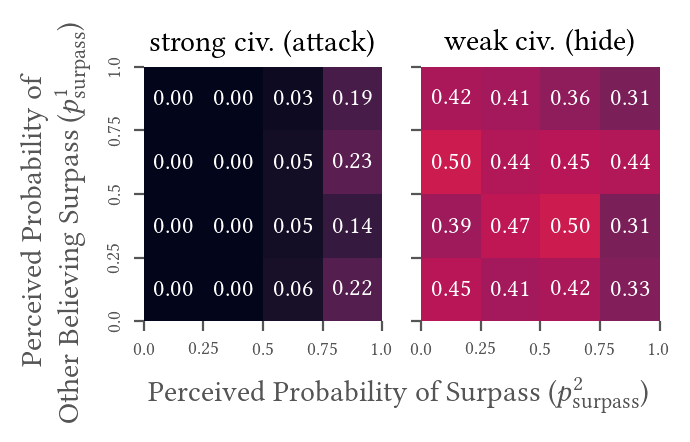

In [11]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(SINGLE_COLUMN_FIG_WIDTH, 2),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)

# names of the different actions coded as 0, 1 or 2
action_names = {0: "attack", 1: "hide", 2: "no action"}
agent_names = {0: "strong civ. (attack)", 1: "weak civ. (hide)"}

# which action to display in the figure for each agent
actor_display_action = {0: 0, 1: 1}

for plot_column, actor in enumerate((0, 1)):
    # determine the action to display for this actor
    action = actor_display_action[actor]

    # choose the axes to plot on
    ax = axs[plot_column]

    # find correct subset of data
    subset = action_data[(action_data["actor"] == actor)]

    # calculate proportions within each bin
    action_proportions = subset.groupby(["prob_surpass_0_bin", "prob_surpass_1_bin"])[
        "action"
    ].value_counts(normalize=True)
    action_proportions = action_proportions.unstack(level=2, fill_value=0)
    action_proportions = action_proportions.reset_index()
    action_proportions["prob_surpass_0_bin"] = np.round(
        pd.IntervalIndex(action_proportions["prob_surpass_0_bin"]).mid, 3
    )
    action_proportions["prob_surpass_1_bin"] = np.round(
        pd.IntervalIndex(action_proportions["prob_surpass_1_bin"]).mid, 3
    )

    # calculate total number of different actions taken in each bin. These are needed
    # for confidence interval calculations
    action_counts = subset.groupby(["prob_surpass_0_bin", "prob_surpass_1_bin"])[
        "action"
    ].value_counts()
    action_counts = action_counts.unstack(level=2, fill_value=0)
    action_counts = action_counts.reset_index()
    action_counts["prob_surpass_0_bin"] = np.round(
        pd.IntervalIndex(action_counts["prob_surpass_0_bin"]).mid, 3
    )
    action_counts["prob_surpass_1_bin"] = np.round(
        pd.IntervalIndex(action_counts["prob_surpass_1_bin"]).mid, 3
    )

    # make sure action we want to plot is present
    if action not in action_proportions.columns:
        action_proportions[action] = 0
    if action not in action_counts.columns:
        action_counts[action] = 0

    # turn into rectangular format
    action_proportions = action_proportions.pivot(
        index="prob_surpass_0_bin", columns="prob_surpass_1_bin", values=action
    )
    action_counts = action_counts.pivot(
        index="prob_surpass_0_bin", columns="prob_surpass_1_bin", values=action
    )

    # reverse rows
    action_proportions = action_proportions.iloc[::-1]
    action_counts = action_counts.iloc[::-1]

    # calculate error margin (95% confidence interval)
    proportion_error_margins = 1.96 * np.sqrt(
        action_proportions * (1 - action_proportions) / action_counts
    )
    print(
        f"Confidence intervals for {agent_names[actor]}, attack reward {attack_reward}"
    )
    print(proportion_error_margins)

    # plot heat map
    map = sns.heatmap(
        action_proportions, ax=ax, vmin=0, vmax=1, annot=True, cbar=False, fmt=".2f"
    )

    ax.set_title(agent_names[actor], fontsize="large")

    ax.set_xlabel("")
    ax.set_ylabel("")

    # add ticks in the correct places (before and after each cell)
    # they need to be reversed for the vertical axis because it is already reversed
    ax.set_xticks(np.arange(len(prob_bins)), prob_bins)
    ax.set_yticks(np.arange(len(prob_bins)), prob_bins[::-1])

fig.supxlabel(
    r"Perceived Probability of Surpass ($p_{\mathrm{surpass}}^2$)",
    color=plt.rcParams["xtick.color"],
    x=0.58,
)
fig.supylabel(
    r"Perceived Probability of"
    + "\n"
    + "Other Believing Surpass ($p_{\mathrm{surpass}}^1$)",
    color=plt.rcParams["xtick.color"],
    ma="center",
)

# plt.savefig("paper/experiment7.pdf")
plt.show()